<a href="https://colab.research.google.com/github/vlady98ish/Colab/blob/main/HW_2_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports



In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


#Init Array of data for future graph

In [3]:
mean_epocs = []
std_epocs = []


#Init Linear Layer Class

In [4]:
class Linear(torch.nn.Module):
  def __init__(self, in_features: int, out_features: int, bias: bool = True, device=None, dtype=None) -> None:
    factory_kwargs = {'device': device, 'dtype': dtype}
    super(Linear, self).__init__()
    self.in_features = in_features
    self.out_features = out_features
    self.weight = nn.Parameter(torch.empty((out_features, in_features), **factory_kwargs))
    if bias:
        self.bias = nn.Parameter(torch.empty(out_features, **factory_kwargs))
    else:
        self.register_parameter('bias', None)
    self.reset_parameters()

  def reset_parameters(self) -> None:
    self.weight = nn.Parameter(torch.rand([self.out_features, self.in_features]))
    if self.bias is not None:
      self.bias = nn.Parameter(torch.rand([self.out_features]))

  def forward(self, input: torch.Tensor) -> torch.Tensor:
    return torch.matmul(input, torch.transpose(self.weight,0,1)) + self.bias

  def extra_repr(self) -> str:
    return 'in_features={}, out_features={}, bias={}'.format(
        self.in_features, self.out_features, self.bias is not None
      )

#Init BTU Class

In [5]:
class BTU(torch.nn.Module):
  def __init__(self, T=0.2, inplace: bool = False):
      super(BTU, self).__init__()
      self.T = T

  def forward(self, input: torch.Tensor) -> torch.Tensor:
      return 1 / (1 + torch.exp(-input/self.T))

#Init XOR Model

In [6]:
dim = 2
out_dim = 1


x_train = torch.tensor([[0, 0], [0, 1], [1, 0], [1, 1]], requires_grad=True, dtype=torch.float32)
print("X_Train tensor:",x_train)
t_train = torch.tensor([[0], [1], [1], [0]], dtype=torch.float32)
print("T_Train tensor:",t_train)

x_validation = torch.tensor([[0, 0],[0, 1],[1, 0],[1, 1],[1,0.1],[1,0.9],[0.9,0.9],[0.1,0.9]], requires_grad=True, dtype=torch.float32)
print("X_Validation tensor:",x_validation)
t_validation = torch.tensor([[0], [1], [1], [0],[1],[0],[0],[1]])
print("T_Validation tensor:",t_validation)


class XOR_Net_Model(nn.Module):
  def __init__(self,num_hidden, bypass=True):
    super().__init__()
    self.bypass = bypass
    self.hidden = Linear(dim, num_hidden)
    if self.bypass:
      self.output = Linear(num_hidden + dim, out_dim)
    else:
      self.output = Linear(num_hidden, out_dim)
    self.BTU = BTU(0.5)

  def forward(self, input):
    z1 = self.hidden(input)
    y1 = self.BTU(z1)
    if self.bypass:
      y1_concat = torch.cat((input, y1), 1)
      z2 = self.output(y1_concat)
    else:
      z2 = self.output(y1)
    return self.BTU(z2)

X_Train tensor: tensor([[0., 0.],
        [0., 1.],
        [1., 0.],
        [1., 1.]], requires_grad=True)
T_Train tensor: tensor([[0.],
        [1.],
        [1.],
        [0.]])
X_Validation tensor: tensor([[0.0000, 0.0000],
        [0.0000, 1.0000],
        [1.0000, 0.0000],
        [1.0000, 1.0000],
        [1.0000, 0.1000],
        [1.0000, 0.9000],
        [0.9000, 0.9000],
        [0.1000, 0.9000]], requires_grad=True)
T_Validation tensor: tensor([[0],
        [1],
        [1],
        [0],
        [1],
        [0],
        [0],
        [1]])


#Init Loss Function

In [7]:
def Loss(out, t_train):
  return -torch.sum(t_train * torch.log(out) + (1.0 - t_train) * torch.log(1.0 - out))  # Cross Entropy loss function

#Train Function

In [8]:
def train(model, x_train, t_train, optimizer):
  y_pred = model(x_train)
  loss = Loss(y_pred, t_train)

  # zero gradients berfore running the backward pass
  optimizer.zero_grad()

  # backward pass to compute the gradient of loss
  # backprop + accumulate 
  loss.backward()

  # update params
  optimizer.step()
  return loss

#Test Function

In [9]:
# define test step operation:
def test(model, x_test, t_test):
  loss = Loss(model(x_test), t_test)
  return loss

#Print results of experiment

In [10]:
def print_results(epocs_arr,validation_loss_arr,train_loss_arr, bad_training_count):
  mean_of_epocs = torch.mean(torch.FloatTensor(epocs_arr))
  std_of_epocs = torch.std(torch.FloatTensor(epocs_arr)) 
  mean_validation = torch.mean(torch.FloatTensor(validation_loss_arr))
  std_validation = torch.std(torch.FloatTensor(validation_loss_arr)) 
  mean_loss = torch.mean(torch.FloatTensor(train_loss_arr))
  std_loss = torch.std(torch.FloatTensor(train_loss_arr)) 



  mean_epocs.append(mean_of_epocs)
  std_epocs.append(std_of_epocs)
  print("-----------------------------------------------------\n")
  print(f"Mean of epocs = {mean_of_epocs} \nStandard deviation of epocs = {std_of_epocs}\n")
  print(f"Mean of validation loss = {mean_validation} \nStandard deviation of validation loss = {std_validation}\n")
  print(f"Mean of train  loss = {mean_loss} \nStandard deviation of train loss = {std_loss}\n")
  print(f"Bad training count = {bad_training_count}")


#MODEL RUN FUNCTION
10 runs

In [11]:
def model_run10(learning_rate,hidden,bypass,epocs):
  good_training_count =0
  bad_training_count = 0
  epoc_count = []
  validation_loss_data = []
  training_loss_data = []
  parameters_of_good_training =[]
  while(good_training_count!=10):
    model = XOR_Net_Model(hidden, bypass)
    
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    counter_of_10 = 0
    previous_loss = None
 
  
    for i in range(epocs):
      if(i == 0):
        train_loss = train(model, x_train, t_train, optimizer)
        
        validation_loss = test(model,x_validation,t_validation)
        previous_loss = validation_loss
      else:
        train_loss = train(model, x_train, t_train, optimizer)
        
        validation_loss = test(model,x_validation,t_validation)
        difference = previous_loss - validation_loss
        
      
        if (difference <= 0.0001 and validation_loss<0.2):
          counter_of_10+=1
        else:
          counter_of_10 = 0
        if counter_of_10 == 10:
          print(f"--------------------------------------------------------------------------------------------------------------------")
          print(f"Good train: number of epocs = {i}" )
          epoc_count.append(i)
          validation_loss_data.append(validation_loss)
          training_loss_data.append(train_loss)
          good_training_count+=1

          break
        elif i == 40000:
          print(f"--------------------------------------------------------------------------------------------------------------------")
          print(f"Bad train: number of epocs = {i}")
          bad_training_count+=1
          break  
        previous_loss = validation_loss
        ###MY CODE#####

        # print("\n Epoc: %s, train loss: %s" % (i, train_loss))
        # print("\n Epoc: %s, validation loss: %s" % (i, validation_loss))
        # print(model(x_train))
  print_results(epoc_count,validation_loss_data,training_loss_data, bad_training_count)
  print("--------------------------------------------------\n")
  print("Hyper Parameters")
  print(f"Learning Rate = {learning_rate}\n Num of hidden neurons = {hidden} \n Bypass = {bypass} \n Max epocs ={epocs}")

#Training

#<b>First Test</b><br>
1-Test with Learning rate = 0.1<br>
2- Count of hidden neuron = 2<br>
3 - Bypass = True


In [12]:
l_rate = 0.1
num_hidden = 2

bypass = True
num_epocs = 400000

In [13]:
model_run10(l_rate,num_hidden,bypass,num_epocs)

--------------------------------------------------------------------------------------------------------------------
Good train: number of epocs = 1635
--------------------------------------------------------------------------------------------------------------------
Good train: number of epocs = 1253
--------------------------------------------------------------------------------------------------------------------
Good train: number of epocs = 1245
--------------------------------------------------------------------------------------------------------------------
Good train: number of epocs = 1232
--------------------------------------------------------------------------------------------------------------------
Good train: number of epocs = 1650
--------------------------------------------------------------------------------------------------------------------
Good train: number of epocs = 1217
----------------------------------------------------------------------------------------

#<b>Second Test</b><br>
1-Test with Learning rate = 0.1<br>
2- Count of hidden neuron = 2<br>
3 - Bypass = False

In [14]:
l_rate = 0.1
num_hidden = 2
bypass = False


In [15]:
model_run10(l_rate,num_hidden,bypass,num_epocs)

--------------------------------------------------------------------------------------------------------------------
Good train: number of epocs = 1228
--------------------------------------------------------------------------------------------------------------------
Good train: number of epocs = 1079
--------------------------------------------------------------------------------------------------------------------
Good train: number of epocs = 2024
--------------------------------------------------------------------------------------------------------------------
Good train: number of epocs = 1377
--------------------------------------------------------------------------------------------------------------------
Bad train: number of epocs = 40000
--------------------------------------------------------------------------------------------------------------------
Bad train: number of epocs = 40000
----------------------------------------------------------------------------------------

#<b>Third Test</b><br>
1-Test with Learning rate = 0.1<br>
2- Count of hidden neuron = 4<br>
3 - Bypass = True

In [16]:
l_rate = 0.1
num_hidden = 4
bypass = True


In [17]:
model_run10(l_rate,num_hidden,bypass,num_epocs)

--------------------------------------------------------------------------------------------------------------------
Good train: number of epocs = 1318
--------------------------------------------------------------------------------------------------------------------
Good train: number of epocs = 1295
--------------------------------------------------------------------------------------------------------------------
Good train: number of epocs = 1208
--------------------------------------------------------------------------------------------------------------------
Good train: number of epocs = 912
--------------------------------------------------------------------------------------------------------------------
Good train: number of epocs = 1626
--------------------------------------------------------------------------------------------------------------------
Good train: number of epocs = 1155
-----------------------------------------------------------------------------------------

#<b>Fourth Test</b><br>
1-Test with Learning rate = 0.1<br>
2- Count of hidden neuron = 4<br>
3 - Bypass = False

In [18]:
l_rate = 0.1
num_hidden = 4
bypass = False

In [19]:
model_run10(l_rate,num_hidden,bypass,num_epocs)

--------------------------------------------------------------------------------------------------------------------
Good train: number of epocs = 1220
--------------------------------------------------------------------------------------------------------------------
Good train: number of epocs = 1206
--------------------------------------------------------------------------------------------------------------------
Good train: number of epocs = 1062
--------------------------------------------------------------------------------------------------------------------
Good train: number of epocs = 977
--------------------------------------------------------------------------------------------------------------------
Good train: number of epocs = 1044
--------------------------------------------------------------------------------------------------------------------
Good train: number of epocs = 1028
-----------------------------------------------------------------------------------------

#<b>Fifth Test</b><br>
1-Test with Learning rate = 0.01<br>
2- Count of hidden neuron = 2<br>
3 - Bypass = True

In [20]:
l_rate = 0.01
num_hidden = 2
bypass = True


In [21]:
model_run10(l_rate,num_hidden,bypass,num_epocs)

--------------------------------------------------------------------------------------------------------------------
Good train: number of epocs = 13562
--------------------------------------------------------------------------------------------------------------------
Good train: number of epocs = 13312
--------------------------------------------------------------------------------------------------------------------
Good train: number of epocs = 10007
--------------------------------------------------------------------------------------------------------------------
Good train: number of epocs = 12437
--------------------------------------------------------------------------------------------------------------------
Good train: number of epocs = 9748
--------------------------------------------------------------------------------------------------------------------
Good train: number of epocs = 7516
------------------------------------------------------------------------------------

#<b>Six Test</b><br>
1-Test with Learning rate = 0.01<br>
2- Count of hidden neuron = 2<br>
3 - Bypass = False

In [22]:
l_rate = 0.01
num_hidden = 2
bypass = False

In [23]:
model_run10(l_rate,num_hidden,bypass,num_epocs)

--------------------------------------------------------------------------------------------------------------------
Bad train: number of epocs = 40000
--------------------------------------------------------------------------------------------------------------------
Bad train: number of epocs = 40000
--------------------------------------------------------------------------------------------------------------------
Bad train: number of epocs = 40000
--------------------------------------------------------------------------------------------------------------------
Good train: number of epocs = 5907
--------------------------------------------------------------------------------------------------------------------
Bad train: number of epocs = 40000
--------------------------------------------------------------------------------------------------------------------
Bad train: number of epocs = 40000
----------------------------------------------------------------------------------------

#<b>Seven Test</b><br>
1-Test with Learning rate = 0.01<br>
2- Count of hidden neuron = 4<br>
3 - Bypass = False

In [24]:
l_rate = 0.01
num_hidden = 4
bypass = False


In [25]:
model_run10(l_rate,num_hidden,bypass,num_epocs)

--------------------------------------------------------------------------------------------------------------------
Good train: number of epocs = 5083
--------------------------------------------------------------------------------------------------------------------
Good train: number of epocs = 5756
--------------------------------------------------------------------------------------------------------------------
Good train: number of epocs = 5861
--------------------------------------------------------------------------------------------------------------------
Good train: number of epocs = 6653
--------------------------------------------------------------------------------------------------------------------
Good train: number of epocs = 6200
--------------------------------------------------------------------------------------------------------------------
Good train: number of epocs = 7251
----------------------------------------------------------------------------------------

#<b>Eight Test</b><br>
1-Test with Learning rate = 0.01<br>
2- Count of hidden neuron = 4<br>
3 - Bypass = True

In [26]:
l_rate = 0.01
hidden = 4
bypass = True

In [27]:
model_run10(l_rate,hidden,bypass,num_epocs)
  

--------------------------------------------------------------------------------------------------------------------
Good train: number of epocs = 11068
--------------------------------------------------------------------------------------------------------------------
Good train: number of epocs = 10090
--------------------------------------------------------------------------------------------------------------------
Good train: number of epocs = 6746
--------------------------------------------------------------------------------------------------------------------
Good train: number of epocs = 6683
--------------------------------------------------------------------------------------------------------------------
Good train: number of epocs = 15404
--------------------------------------------------------------------------------------------------------------------
Good train: number of epocs = 6566
-------------------------------------------------------------------------------------

#<b>Nine Test</b><br>
1-Test with Learning rate = 0.1<br>
2- Count of hidden neuron = 1<br>
3 - Bypass = True

In [28]:
l_rate = 0.1
num_hidden = 1
bypass = True


In [29]:
model_run10(l_rate,num_hidden,bypass,num_epocs)

--------------------------------------------------------------------------------------------------------------------
Good train: number of epocs = 1731
--------------------------------------------------------------------------------------------------------------------
Good train: number of epocs = 1627
--------------------------------------------------------------------------------------------------------------------
Good train: number of epocs = 1712
--------------------------------------------------------------------------------------------------------------------
Good train: number of epocs = 1704
--------------------------------------------------------------------------------------------------------------------
Good train: number of epocs = 1812
--------------------------------------------------------------------------------------------------------------------
Good train: number of epocs = 1667
----------------------------------------------------------------------------------------

#Plot function

In [30]:
def plot_function(x,y,x_name,y_name):
  plt.scatter(x, y)
  plt.title(f"{x_name} and {y_name}")
  plt.xlabel(x_name)
  plt.ylabel(y_name)
  plt.show


#Plot graphs

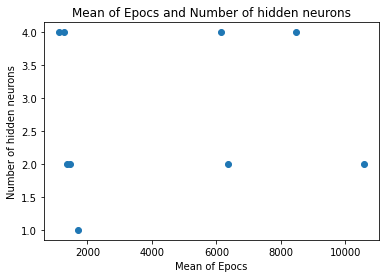

In [31]:
num_hidden=[2,2,4,4,2,2,4,4,1]
#First graph 
plot_function(mean_epocs,num_hidden, "Mean of Epocs", "Number of hidden neurons")






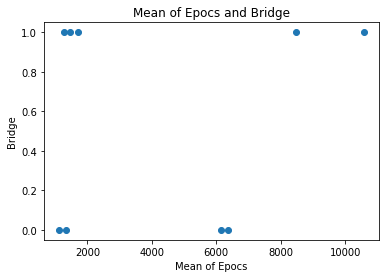

In [32]:
#Second graph  
bridge =[True,False,True,False,True,False,False,True,True] 
plot_function(mean_epocs,bridge, "Mean of Epocs", "Bridge")

[tensor(205.5620), tensor(268.5460), tensor(204.1274), tensor(108.1000), tensor(2626.2107), tensor(465.6556), tensor(608.3008), tensor(2981.1729), tensor(54.9837)]


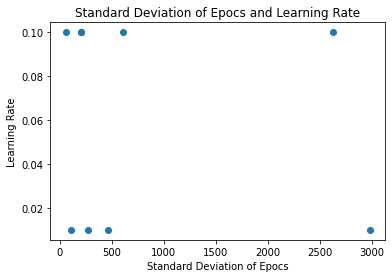

In [33]:
# #Third graph
learning_rate_arr = [0.1,0.01,0.1,0.01,0.1,0.01,0.1,0.01,0.1]
print(std_epocs)
plot_function(std_epocs,learning_rate_arr, "Standard Deviation of Epocs", "Learning Rate")